In [1]:
import os
os.chdir("../") 
!pwd

/home/ubuntu/Breast-Classified


In [54]:
import csv
import cv2
import numpy as np
import os
import tensorflow as tf

try:
    import openslide
except ImportError:
    openslide = None


class Dataset(object):
    """ Data list CSV parser """
    def __init__(
        self,
        csv_path,
        slide_dir,
        slide_file_extension=".svs",
        target_size=None,
        resize_ratio=0.2,
        slide_reader="openslide",
        snapshot_path=None,
    ):
        self.target_size = target_size
        self.resize_ratio = resize_ratio
        self.slide_reader = slide_reader
        self.snapshot_path = snapshot_path

        # Parse CSV to get paths
        self.slide_path_list = []
        self.y_true_list = []
        with open(csv_path) as f:
            reader = csv.reader(f)
            for row in reader:
                slide_name = row[0]
                y_true = int(row[1])
                slide_path = os.path.join(
                    slide_dir, 
                    "{}{}".format(slide_name, slide_file_extension)
                )
                assert os.path.exists(slide_path), \
                    "{} not found while parsing {}.".format(slide_path, csv_path)
                self.slide_path_list.append(slide_path)
                self.y_true_list.append(y_true)

    def __len__(self):
        return len(self.slide_path_list)

    def __getitem__(self, idx):
        slide_path = self.slide_path_list[idx]
        y_true = self.y_true_list[idx]

        if self.slide_reader == "openslide":
            img = _read_slide_openslide(slide_path, self.resize_ratio, self.target_size)
        else:
            raise NotImplementedError(
                "{} is not a supported slide reader.".format(self.slide_reader)
            )


        if self.snapshot_path != None:
            os.makedirs(self.snapshot_path, exist_ok=True)
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(
                os.path.join(self.snapshot_path, "dataset_snapshot.tiff"),
                img_bgr,
            )

        return img, y_true

    def get_slide_path(self, idx):
        return self.slide_path_list[idx]

    def get_y_true(self, idx):
        return self.y_true_list[idx]
    
def _read_slide_openslide(
    slide_path,
    resize_ratio,
    target_size=None,
):
    assert openslide != None, \
        "Please install beforehand or select another slide loader."

    slide = openslide.open_slide(slide_path)

    if "aperio.AppMag" in slide.properties:
        mag = int(float(slide.properties["aperio.AppMag"]))
        if mag >= 40:
            pix_dim = 0.25
        elif mag <= 20:
            pix_dim = 0.5
        else:
            assert False
        hamamatsu_pix_dim = 0.46
        resize_ratio = resize_ratio * (pix_dim / hamamatsu_pix_dim)

    w, h = slide.dimensions
    if target_size == None:
        target_size = (int(w * resize_ratio), int(h * resize_ratio))

    def get_region(loc_w, loc_h, src_sz_w, src_sz_h, req_sz_w, req_sz_h):
        downsample_factor_w = src_sz_w / req_sz_w
        downsample_factor_h = src_sz_h / req_sz_h
        downsample_factor = min(downsample_factor_w, downsample_factor_h)

        target_level = 0
        for level in range(len(slide.level_downsamples)):
            if slide.level_downsamples[level] <= downsample_factor:
                target_level = level

        src_sz_w_downsampled = int(src_sz_w / slide.level_downsamples[target_level])
        src_sz_h_downsampled = int(src_sz_h / slide.level_downsamples[target_level])

        img_rgba = slide.read_region(
            location=(loc_w, loc_h),
            level=target_level,
            size=(src_sz_w_downsampled, src_sz_h_downsampled)
        )

        img_rgba = np.array(img_rgba)
        img_rgb = cv2.cvtColor(img_rgba, cv2.COLOR_RGBA2RGB)
        img = cv2.resize(img_rgb, (req_sz_w, req_sz_h), interpolation=cv2.INTER_CUBIC)
        return img

    img = _read_slide(
        slide_path,
        get_region,
        (0, 0),
        (w, h),
        target_size,
        resize_ratio,
    )
    return img

def _read_slide(
    slide_path,
    get_region_fn,
    coord,
    src_sz,
    dst_sz,
    resize_ratio,
):
    loc_w, loc_h = coord
    src_sz_w, src_sz_h = src_sz
    dst_sz_w, dst_sz_h = dst_sz

    # Get resized image
    req_sz_w, req_sz_h = int(src_sz_w * resize_ratio), int(src_sz_h * resize_ratio)
    img = get_region_fn(loc_w, loc_h, src_sz_w, src_sz_h, req_sz_w, req_sz_h)
   
    # Do cropping and pirnt warning
    h, w, c = img.shape
    cropped = False
    if w > dst_sz_w:
        index = int(w - dst_sz_w) // 2
        img = img[:, index: (index + dst_sz_w), :]
        cropped = True
    if h > dst_sz_h:
        index = int(h - dst_sz_h) // 2
        img = img[index: (index + dst_sz_h), :, :]
        cropped = True

    if cropped:
        print('Slide {} with original size {}x{}, resized size {}x{} exceeds the target size {}x{}. Crop it.'.format(
            slide_path, src_sz_w, src_sz_h, w, h, dst_sz_w, dst_sz_h
        ))
     
    # Do pading
    pad_color = (255, 255, 255)
    h, w, c = img.shape
    if w < dst_sz_w:
        l = (int(dst_sz_w - w)) // 2
        r = dst_sz_w - w - l
    else:
        l = 0
        r = 0
    if h < dst_sz_h:
        t = (int(dst_sz_h - h)) // 2
        b = dst_sz_h - h - t
    else:
        t = 0
        b = 0
    img = cv2.copyMakeBorder(
        img, t, b, l, r,
        cv2.BORDER_CONSTANT, value=pad_color
    )

    return img


In [13]:
import cv2
from imgaug import augmenters as iaa
import numpy as np
import os
from PIL import Image, ImageOps
import tensorflow as tf
import time
import traceback
import joblib
from pathlib import Path

def preprocess_input(img):
    return (np.array(img).astype(np.float32) - 127.5) / 127.5

def inverse_preprocess_input(img):
    x = np.array(img) * 127.5 + 127.5
    x = np.minimum(255.0, np.maximum(0.0, x))
    x = x.astype(np.uint8)
    return x

class WholeSlideDataloader(tf.keras.utils.Sequence):
    def __init__(
        self, 
        dataset,
        augment,
        shuffle,
        num_classes,
        batch_size=1,
        snapshot_path=None,
    ):
        self.dataset = dataset
        self.augment = augment
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.snapshot_path = snapshot_path

        self._reinit_shuffle_list()
    def _reinit_shuffle_list(self):
        self.shuffle_list = np.arange(len(self.dataset))
        if self.shuffle:
            np.random.shuffle(self.shuffle_list)

    def __len__(self):
        return len(self.dataset) // self.batch_size

    def __getitem__(self, idx):
        begin_idx = idx * self.batch_size
        end_idx = (idx + 1) * self.batch_size

        x_batch = []
        y_batch = []
        for shuffle_list_idx in range(begin_idx, end_idx):
            dataset_idx = self.shuffle_list[shuffle_list_idx]
            loaded = False
            while not loaded:
                try:
                    img, label = self.dataset[dataset_idx]
                    loaded = True
                except Exception as e:
                    print(traceback.format_exc())
                    print(
                        "Error occurs while loading {} . Retry after 5 seconds.".format(
                            self.dataset.get_slide_path(dataset_idx)
                        )
                    )
                    time.sleep(5)

            if self.augment:
                if img.size < 4 * 1024 * 1024 * 1024:
                    img = _get_augmentor().augment_image(img)
                else:
                    # If the image is too large, imgaug will fail on affine transformation. Use PIL instead.
                    img = _get_augmentor_wo_affine().augment_image(img)
                    img = Image.fromarray(img)
                    angle = np.random.uniform(0.0, 360.0)
                    translate = tuple(np.random.randint(-220, 220, size=[2]))
                    img = img.rotate(angle, resample=Image.NEAREST, translate=translate, fillcolor=(255, 255, 255))
                    img = np.array(img)

            if self.snapshot_path != None:
                os.makedirs(self.snapshot_path, exist_ok=True)
                img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                cv2.imwrite(
                    os.path.join(self.snapshot_path, "dataloader_snapshot.tiff"),
                    img_bgr,
                )

            img = preprocess_input(img)
            y = np.zeros(shape=[self.num_classes])
            y[label] = 1.0
            
            x_batch.append(img)
            y_batch.append(y)
        return np.array(x_batch), np.array(y_batch)

    def on_epoch_end(self):
        self._reinit_shuffle_list()

    def get_slide_path(self, idx):
        dataset_idx = self.shuffle_list[idx]
        return self.dataset.get_slide_path(dataset_idx)

    def get_y_true(self, idx):
        dataset_idx = self.shuffle_list[idx]
        return self.dataset.get_y_true(dataset_idx)

    def get_dataset_idx(self, idx):
        return self.shuffle_list[idx]

    

def _get_augmentor():
    augmentation = iaa.Sequential([
        iaa.Fliplr(0.5, name="FlipLR"),
        iaa.Flipud(0.5, name="FlipUD"),
        iaa.Affine(
            translate_percent=(-0.025, 0.025),
            rotate=(0, 360),
            order=3, # Bicubic interpolation
            cval=255,
            mode='constant',
            name='affine',
        ),
        iaa.contrast.LinearContrast(alpha=(0.5, 1.5)),
        iaa.color.MultiplyBrightness(mul=(0.65, 1.35)),
        iaa.color.AddToHueAndSaturation(value=(-32, 32), per_channel=True),
    ])    
    return augmentation

def _get_augmentor_wo_affine():
    augmentation = iaa.Sequential([
        iaa.Fliplr(0.5, name="FlipLR"),
        iaa.Flipud(0.5, name="FlipUD"),
        iaa.contrast.LinearContrast(alpha=(0.5, 1.5)),
        iaa.color.MultiplyBrightness(mul=(0.65, 1.35)),
        iaa.color.AddToHueAndSaturation(value=(-32, 32), per_channel=True),
    ])    
    return augmentation

In [14]:
class MILDataloader(WholeSlideDataloader):
    MIL_WHITE_THRESHOLD = 220
    MIL_EM_GAUSSIAN_KERNEL_SIZE = 3
    MIL_EM_P1 = 1
    MIL_EM_P2 = 30

    def __init__(
        self, 
        dataset,
        augment,
        shuffle,
        num_classes,
        mil_model,
        batch_size=1,
        snapshot_path=None,
        mil_patch_size=[224, 224],
        mil_infer_batch_size=32,
        mil_use_em=False,
        mil_k=1,
        mil_skip_white=True,
    ):
        super(MILDataloader, self).__init__(
            dataset=dataset,
            augment=augment,
            shuffle=shuffle,
            num_classes=num_classes,
            batch_size=batch_size,
            snapshot_path=snapshot_path
        )
        self.mil_model = mil_model
        self.mil_patch_size = mil_patch_size
        self.mil_infer_batch_size = mil_infer_batch_size
        self.mil_use_em = mil_use_em
        self.mil_k = mil_k
        self.mil_skip_white = mil_skip_white
            
    def __getitem__(self, idx):
        x_batch_wsi, y_batch_wsi = super(MILDataloader, self).__getitem__(idx)

        x_batch = []
        y_batch = []
        for i in range(self.batch_size):
            x = x_batch_wsi[i]
            y = y_batch_wsi[i]

            num_patch_y = x.shape[0] // self.mil_patch_size[1]
            num_patch_x = x.shape[1] // self.mil_patch_size[0]

            mil_infer_dataset = []
            coords = []
            for i in range(num_patch_y):
                for j in range(num_patch_x):
                    sliced_x = x[
                        i * self.mil_patch_size[1]: (i + 1) * self.mil_patch_size[1],
                        j * self.mil_patch_size[0]: (j + 1) * self.mil_patch_size[0],
                        :,
                    ]
                    if (
                        self.mil_skip_white and 
                        np.min(sliced_x) > preprocess_input(self.MIL_WHITE_THRESHOLD)
                    ):
                        continue
                    mil_infer_dataset.append(sliced_x)
                    coords.append((j, i))
            mil_infer_dataset = np.array(mil_infer_dataset)

            mil_infer_res = []
            for begin_idx in range(0, len(mil_infer_dataset), self.mil_infer_batch_size):
                end_idx = np.minimum(len(mil_infer_dataset), begin_idx + self.mil_infer_batch_size)
                mil_infer_res.append(
                    self.mil_model.predict_on_batch(
                         mil_infer_dataset[begin_idx: end_idx]
                    )
                )
              
            mil_infer_res = np.concatenate(mil_infer_res, axis=0)
            
            benign_rate = mil_infer_res[:, 0]

            if not self.mil_use_em:
                print("useem {}".format(self.mil_use_em))
                top_k_indices = np.argsort(benign_rate)[0: self.mil_k]
                for index in top_k_indices:
                    x_batch.append(mil_infer_dataset[index])
                    y_batch.append(y)
            else:
                res_map = np.zeros([num_patch_y, num_patch_x, self.num_classes - 1]) # Excluding non-cancer
                for i in range(len(mil_infer_res)):
                    res = mil_infer_res[i]
                    
                    coord = coords[i]
                    
                    res_map[coord[1], coord[0], :] = res[1: ]

                res_map_blurred = cv2.GaussianBlur(
                    res_map, 
                    (self.MIL_EM_GAUSSIAN_KERNEL_SIZE, self.MIL_EM_GAUSSIAN_KERNEL_SIZE),
                    0
                )
                
                if self.num_classes==2:
                    res_map_blurred=res_map_blurred.reshape(res_map_blurred.shape[0], res_map_blurred.shape[1], 1)
                
                mil_infer_res_blurred = []
                for i in range(len(mil_infer_res)):
                    coord = coords[i]
                    
                    res_blurred = res_map_blurred[coord[1], coord[0], :]
                    mil_infer_res_blurred.append(res_blurred)
                mil_infer_res_blurred = np.array(mil_infer_res_blurred)
                
                thres_p1 = np.percentile(mil_infer_res_blurred, 100.0 - self.MIL_EM_P1)

                select = None
                for class_id in range(1, self.num_classes):
                    candidates = mil_infer_res_blurred[:, class_id - 1].tolist()
                    candidates = np.array(candidates)
                    print(candidates.shape)

                    thres_p2 = np.percentile(candidates, 100.0 - self.MIL_EM_P2)
                    thres = np.minimum(thres_p1, thres_p2)
                    print(thres_p1)
                    print(thres_p2)

                    if select is None:
                        select = mil_infer_res_blurred[:, class_id - 1] > thres
                    else:
                        select = np.logical_or(select, mil_infer_res_blurred[:, class_id - 1] > thres)

                no_selected = True
                for i in range(len(mil_infer_res_blurred)):
                    is_select = select[i]
                    if is_select:
                        x_batch.append(mil_infer_dataset[i])
                        y_batch.append(y)
                        no_selected = False

                if no_selected:
                    x_batch.append(mil_infer_dataset[np.argmin(benign_rate)])
                    y_batch.append(y)

        x_batch = np.array(x_batch) # The batch dimension is large as (self.batch_size * self.mil_k).
        y_batch = np.array(y_batch)

        if self.snapshot_path != None:
            os.makedirs(self.snapshot_path, exist_ok=True)
            img = inverse_preprocess_input(x_batch[0])
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(
                os.path.join(self.snapshot_path, "mil_top_patch_snapshot.tiff"),
                img_bgr,
            )

        return x_batch, y_batch

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

input_shape = (224, 224, 3)  # Adjust based on your patches
num_classes = 2  # Replace with your number of classes

model = build_resnet_model(input_shape, num_classes)


In [55]:
train_dataset = Dataset(
            csv_path=Path("label/breast.csv"),
            slide_dir=Path("data"),
            slide_file_extension=".svs",
            target_size=[11500, 11500],
            resize_ratio=0.1,
            slide_reader="openslide",
            snapshot_path=None
        )

In [38]:
len(train_dataset)

15

In [7]:

dataloader = WholeSlideDataloader(
            dataset=train_dataset,
            augment=True,
            shuffle=True,
            num_classes=2,
            batch_size=1,
            snapshot_path=None
        )

In [56]:
train_dataloader = MILDataloader(
            dataset=train_dataset,
            augment=True,
            shuffle=True,
            num_classes=2,
            batch_size=1,
            snapshot_path=None,
            mil_model=model,
            mil_patch_size=[224,224],
            mil_infer_batch_size=32,
            mil_use_em=True,
            mil_k=1,
            mil_skip_white=True
        )

In [10]:
len(train_dataloader)

15

In [57]:
xp_batch, yp_batch = train_dataloader[0]

JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

(2601,)
0.17398868408054113
0.16636662185192108


In [58]:
xp_batch.shape

(88, 224, 224, 3)

In [14]:
#joblib.dump(x_batch,'datapreprocessed/x_batch.joblib')
#joblib.dump(y_batch,'datapreprocessed/y_batch.joblib')

In [29]:
val_dataloader = MILDataloader(
            dataset=train_dataset,
            augment=True,
            shuffle=True,
            num_classes=2,
            batch_size=1,
            snapshot_path=None,
            mil_model=model,
            mil_patch_size=[224,224],
            mil_infer_batch_size=32,
            mil_use_em=True,
            mil_k=1,
            mil_skip_white=True
        )

In [31]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history=model.fit(
            train_dataloader,
            epochs=2,
            steps_per_epoch=15,
            shuffle=False, # Shuffling is already done in dataloader
        )

JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

(25,)
0.5702712647616862
0.46669523417949677


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

(55,)
0.6254698311537504
0.5770432226359844
Epoch 1/2


/home/ubuntu/Breast-Classified/tensorflow-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG comp

(25,)
0.5796950630843639
0.5023084096610546


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

 1/15 ━━━━━━━━━━━━━━━━━━━━ 3:47 16s/step - accuracy: 1.0000 - loss: 0.4762(53,)
0.6187748371064663
0.5571570880711079


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

 2/15 ━━━━━━━━━━━━━━━━━━━━ 1:46 8s/step - accuracy: 1.0000 - loss: 0.3191 (42,)
0.6265433621406554
0.5370648711919784


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

 3/15 ━━━━━━━━━━━━━━━━━━━━ 1:39 8s/step - accuracy: 0.8829 - loss: 1.4037(42,)
0.6050781553983686
0.4663042608648539
 4/15 ━━━━━━━━━━━━━━━━━━━━ 1:18 7s/step - accuracy: 0.7822 - loss: 2.1977

JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

(45,)
0.623147184252739
0.5777434974908828


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

 5/15 ━━━━━━━━━━━━━━━━━━━━ 1:20 8s/step - accuracy: 0.7007 - loss: 2.6661(52,)
0.5934788331389427
0.508208804577589
 6/15 ━━━━━━━━━━━━━━━━━━━━ 1:07 8s/step - accuracy: 0.6673 - loss: 2.8396

JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

(47,)
0.623859164789319
0.5888094574213026
 7/15 ━━━━━━━━━━━━━━━━━━━━ 1:00 8s/step - accuracy: 0.6540 - loss: 2.8894

JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

(33,)
0.5891037540137768
0.5041726388037204


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

 8/15 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.6372 - loss: 2.9323 (87,)
0.6218411773443222
0.609476437419653


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

 9/15 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.6125 - loss: 2.9861(2601,)
0.6205492839217186
0.6183649301528931


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

10/15 ━━━━━━━━━━━━━━━━━━━━ 47s 10s/step - accuracy: 0.6159 - loss: 2.8951(41,)
0.6145135253667832
0.5104267597198486


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

11/15 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - accuracy: 0.6204 - loss: 2.8109 (55,)
0.5979733199626208
0.5020376272499562


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

12/15 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - accuracy: 0.6203 - loss: 2.7483(2601,)
0.6218292526900768
0.6185158491134644


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

13/15 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.6279 - loss: 2.6551(66,)
0.6281275831162929
0.5859216768294573


JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

14/15 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.6316 - loss: 2.5771  (2601,)
0.6194553636014462
0.6184877157211304
15/15 ━━━━━━━━━━━━━━━━━━━━ 154s 10s/step - accuracy: 0.6446 - loss: 2.4244
Epoch 2/2
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


2024-07-14 16:20:30.632216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-14 16:20:30.632518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/local/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [18]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'epoch')

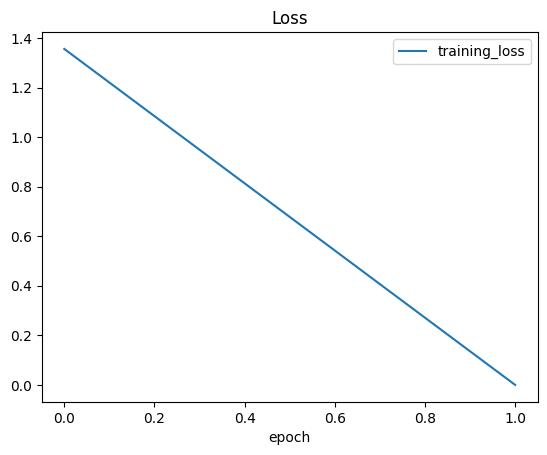

In [33]:
plt.plot(history.history['loss']) 
plt.legend(['training_loss']) 
plt.title('Loss') 
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

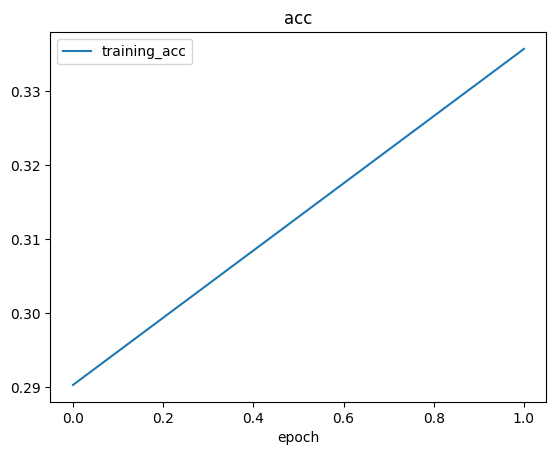

In [21]:
plt.plot(history.history['accuracy']) 
plt.legend(['training_acc']) 
plt.title('acc') 
plt.xlabel('epoch')